In [10]:
!pip3 install lightgbm scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn
# 모델을 위해 필요한 라이브러리 설치(우수 예시에만 있는 부분)

In [11]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold


In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed = 42
seed_everything(seed) # Seed 고정

In [13]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [14]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')
    #df_all['bant_submit'] = (df_all['bant_submit']*4).astype('int64')
    
    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

In [18]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]

S_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

all_x_trains = []
all_y_trains = []
all_x_vals = []
all_y_vals = []

for train_idx, val_idx in S_kfold.split(x_train, list(y_train)):
    tmp_x_train, tmp_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    tmp_y_train, tmp_y_val = y_train[train_idx], y_train[val_idx]
    all_x_trains.append(tmp_x_train)
    all_y_trains.append(list(tmp_y_train))
    all_x_vals.append(tmp_x_val)
    all_y_vals.append(list(tmp_y_val))

In [19]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20,40), 
        'max_depth': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1), 
        'n_estimators': trial.suggest_int('n_estimators', 50,200), 
        'scale_pos_weight':rate,
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 80), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'objective':'binary',
        'random_state': seed,
        'type':'gpu',
        'verbose':-1,
        'n_jobs':-1,
    }
    
    score = []
    for all_x_train, all_y_train, all_x_val, all_y_val in zip(all_x_trains, all_y_trains, all_x_vals, all_y_vals):
        clf = LGBMClassifier(**params, feature_name='auto', categorical_feature = 'auto')
        clf.fit(all_x_train, all_y_train)
        
        y_pred = clf.predict(all_x_val)
        y_true = all_y_val
        score.append(f1_score(y_true,y_pred,labels=[True,False]))
    score = np.mean(score)
    return score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-02-12 11:20:34,078] A new study created in memory with name: no-name-9b58a3ff-da78-4aac-b827-e11719e96cb8
[I 2024-02-12 11:20:38,051] Trial 0 finished with value: 0.8139113168988825 and parameters: {'num_leaves': 27, 'learning_rate': 0.0951207163345817, 'n_estimators': 160, 'min_child_samples': 50, 'colsample_bytree': 0.7468055921327309, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 0.8139113168988825.
[I 2024-02-12 11:20:42,434] Trial 1 finished with value: 0.812985315728248 and parameters: {'num_leaves': 38, 'learning_rate': 0.06051038616257767, 'n_estimators': 156, 'min_child_samples': 6, 'colsample_bytree': 0.9909729556485982, 'reg_alpha': 0.8324426408004217, 'reg_lambda': 2.1233911067827616}. Best is trial 0 with value: 0.8139113168988825.
[I 2024-02-12 11:20:44,758] Trial 2 finished with value: 0.7643528001647145 and parameters: {'num_leaves': 23, 'learning_rate': 0.01915704647548995, 'n_estimators': 95, 'min_child_sample

[I 2024-02-12 11:22:14,953] Trial 23 finished with value: 0.8154879960996345 and parameters: {'num_leaves': 31, 'learning_rate': 0.0825723897832841, 'n_estimators': 169, 'min_child_samples': 61, 'colsample_bytree': 0.7384087163034241, 'reg_alpha': 0.013704228262944538, 'reg_lambda': 1.6299019032388722}. Best is trial 12 with value: 0.8200096793730035.
[I 2024-02-12 11:22:19,434] Trial 24 finished with value: 0.8084043491786843 and parameters: {'num_leaves': 33, 'learning_rate': 0.06539019724507585, 'n_estimators': 152, 'min_child_samples': 71, 'colsample_bytree': 0.8109879523743733, 'reg_alpha': 0.2221679377008119, 'reg_lambda': 3.051174742544866}. Best is trial 12 with value: 0.8200096793730035.
[I 2024-02-12 11:22:24,926] Trial 25 finished with value: 0.8224982097579027 and parameters: {'num_leaves': 37, 'learning_rate': 0.07752713153518055, 'n_estimators': 193, 'min_child_samples': 50, 'colsample_bytree': 0.7408266203276815, 'reg_alpha': 0.32471250028508986, 'reg_lambda': 4.00095329

KeyboardInterrupt: 

In [46]:
best_param = study.best_params
best_param['verbose'] = -1
best_param['random_state'] = seed
best_param['objective'] = 'binary'
best_param['verbose'] = -1
best_param['scale_pos_weight'] = rate
best_param

{'verbose': -1,
 'random_state': 42,
 'objective': 'binary',
 'scale_pos_weight': 11.073593073593074}

In [47]:
best_models = []
for all_x_train, all_y_train in zip(all_x_trains, all_y_trains):
    best_model = LGBMClassifier(**best_param, feature_name='auto', categorical_feature = 'auto')
    best_model.fit(all_x_train, all_y_train)
    best_models.append(best_model)

In [48]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [49]:
train_pred = [best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models]
y = list(df_train['is_converted'])
train_pred = np.mean(train_pred[:],axis=0)
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = np.argmax(train_pred,axis=1)
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]

get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4616     4]
 [  916 50244]]

정확도: 0.9835
정밀도: 0.8344
재현율: 0.9991
F1: 0.9094


In [50]:
threshold

0.3014652475122629

In [51]:
categorical_features = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
                                        ]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [55]:
a_pred = [best_model.predict_proba(x_test) for best_model in best_models]
pred = np.mean(a_pred, axis=0)
pred = [True if i[1]>=threshold else False for i in pred]
#pred = np.argmax(t_pred, axis=1)
sum(pred)

1341

In [56]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [57]:
real = pd.read_csv(r'submission(0.767).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1239  533]
 [ 102 3397]]

정확도: 0.8795
정밀도: 0.9239
재현율: 0.6992
F1: 0.7960


In [58]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

1874

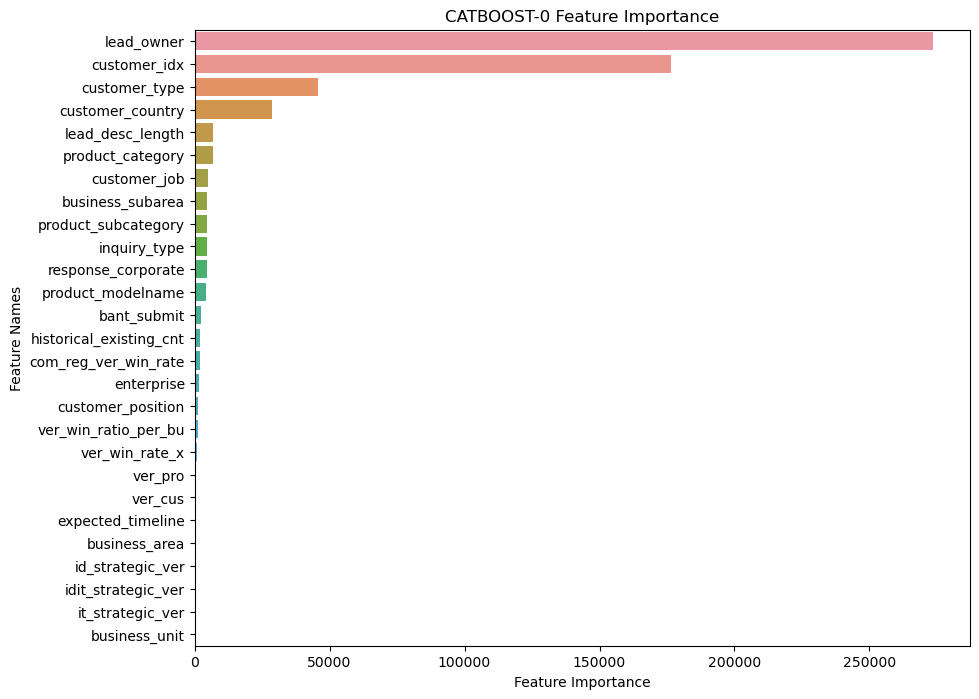

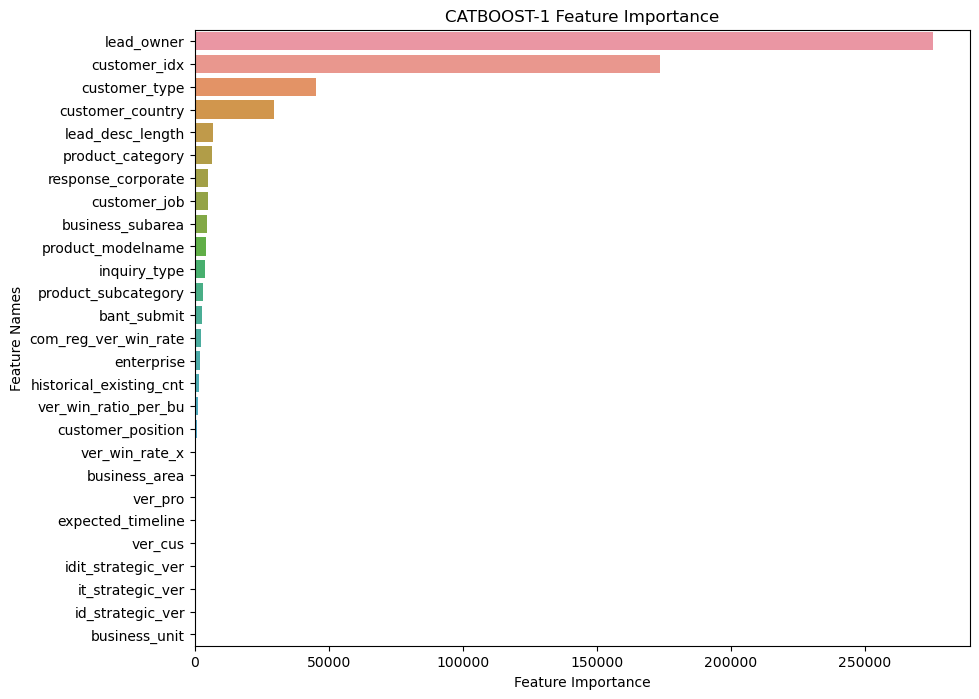

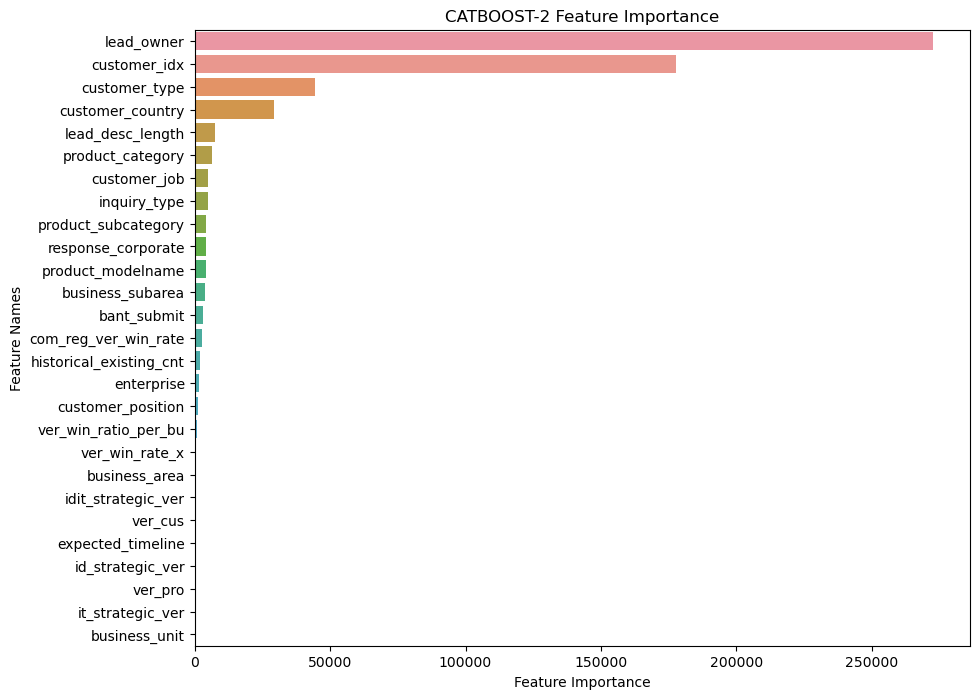

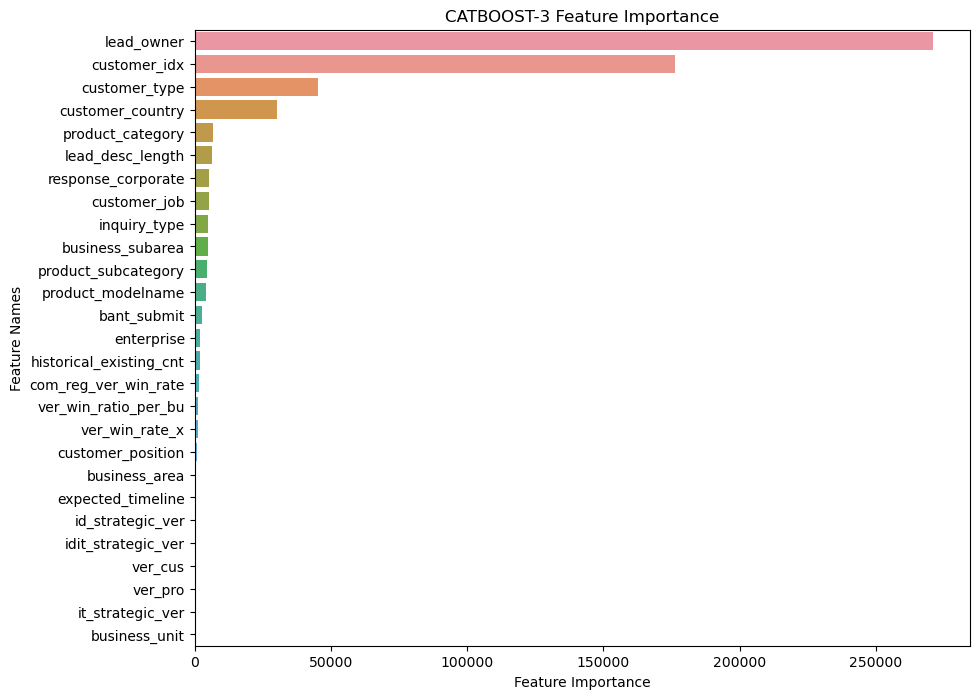

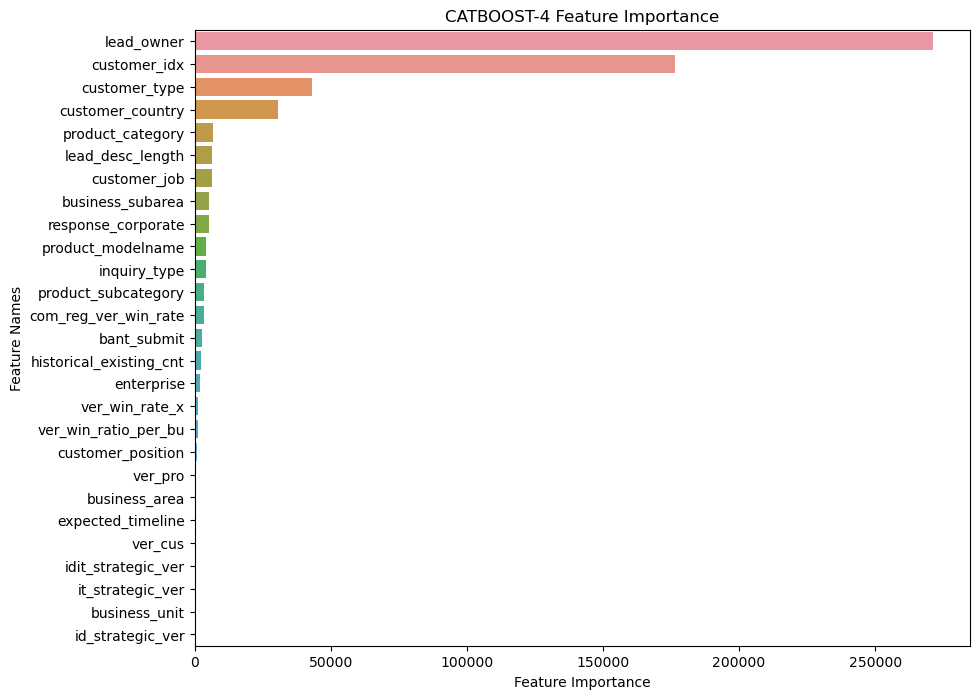

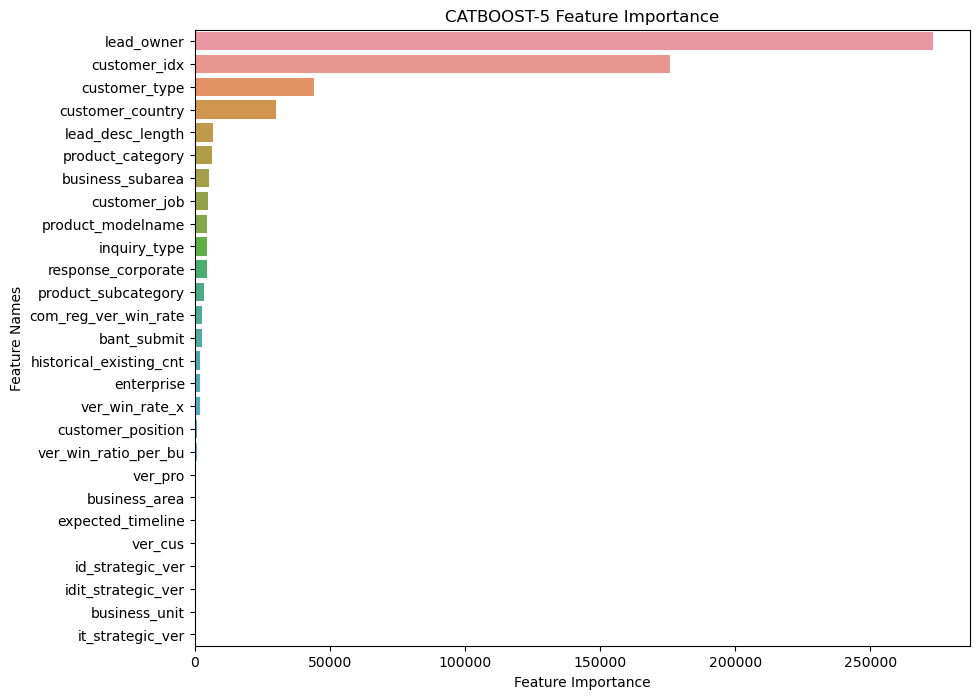

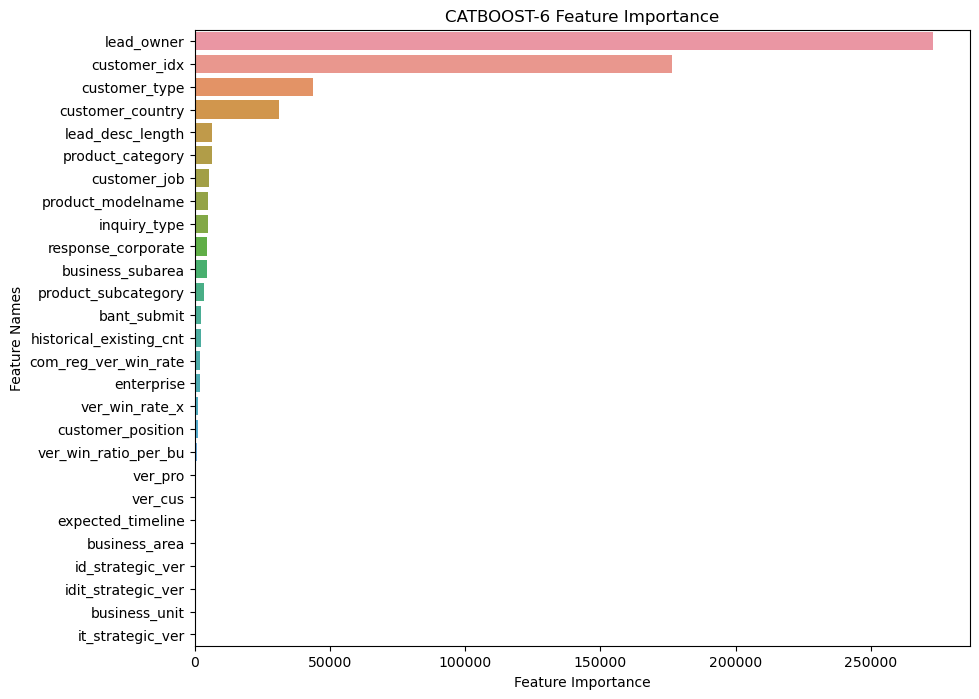

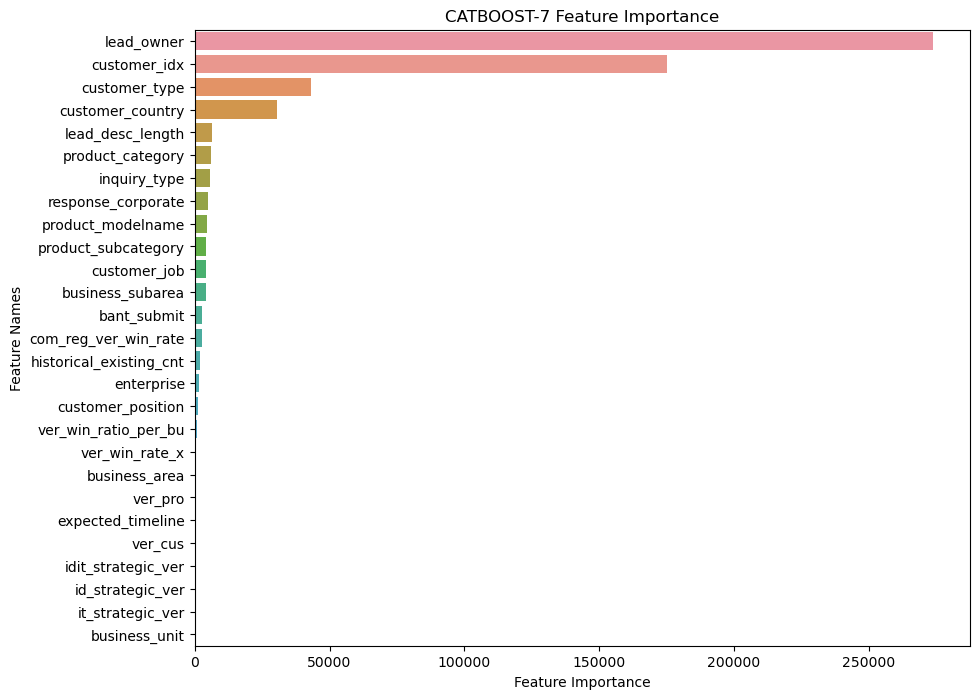

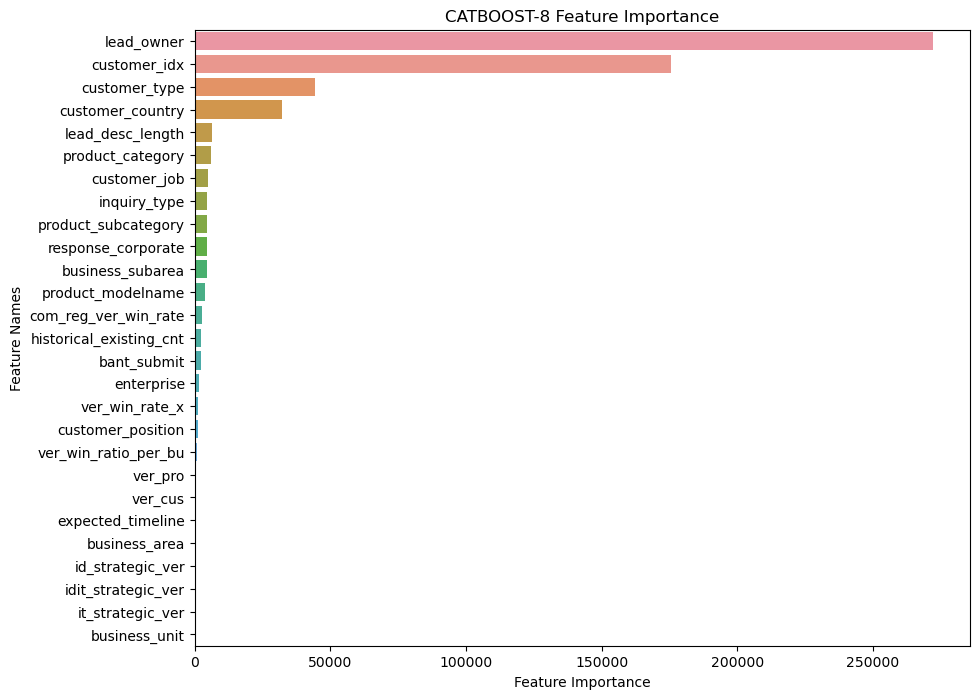

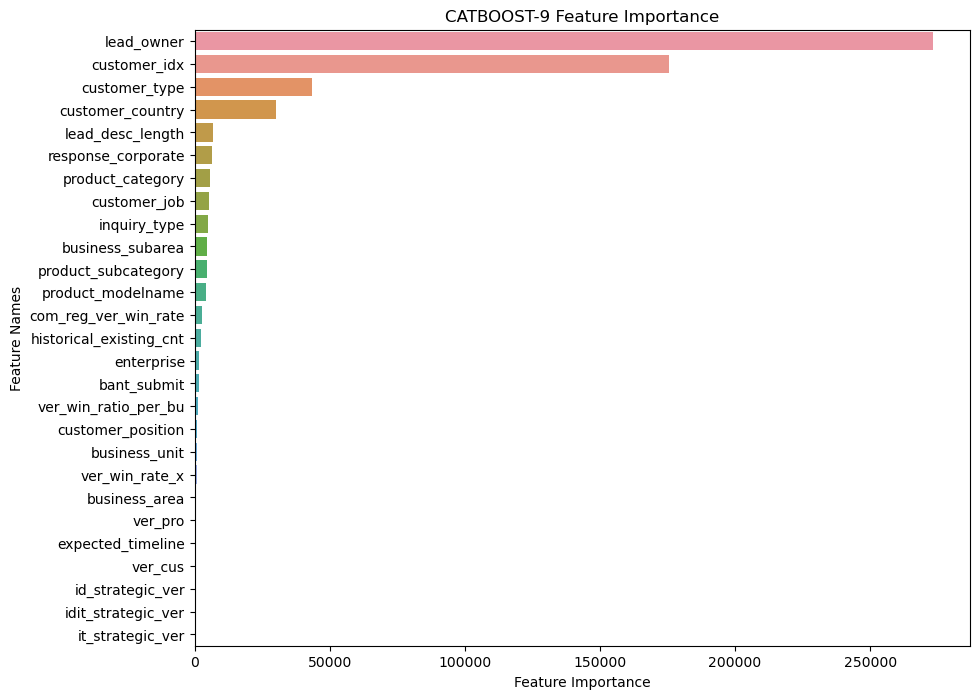

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    

    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
for i in range(10):
    plot_feature_importance(best_models[i].booster_.feature_importance(importance_type='gain'),df_test.drop(['is_converted','id'],axis=1).columns,f'CATBOOST-{i}')
    
    

In [ ]:
# all_train_pool = []
# all_val_pool = []
# all_y_val = []
for i in range(10):
    train_pred = np.mean([best_model.predict_proba(all_x_vals[i]) for best_model in best_models], axis=0)
    train_pred = np.argmax(train_pred, axis=1)
    get_clf_eval(all_y_vals[i], train_pred)